# NST

## import libraries

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import models
import torchvision.transforms.v2 as tfs_v2
import torch.nn as nn
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## class

In [3]:
class ModelStyle(nn.Module):
    def __init__(self):
        super().__init__()
        _model = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
        self.mf = _model.features
        self.mf.requires_grad_(False)
        self.requires_grad_(False)
        self.mf.eval()
        self.idx_out = (0, 5, 10, 19, 28, 34)
        self.num_style_layers = len(self.idx_out) - 1 # последний слой для контента

    def forward(self, x):
        outputs = []
        for indx, layer in enumerate(self.mf):
            x = layer(x)
            if indx in self.idx_out:
                outputs.append(x.squeeze(0))

        return outputs


## functions

In [4]:
def get_content_loss(base_content, target):
  return torch.mean( torch.square(base_content - target) )

In [5]:
def gram_matrix(x):
  channels = x.size(dim=0)
  g = x.view(channels, -1)
  gram = torch.mm(g, g.mT) / g.size(dim=1)
  return gram

In [6]:
def get_style_loss(base_style, gram_target):
  style_weights = [1.0, 0.8, 0.5, 0.3, 0.1]

  _loss = 0
  i = 0
  for base, target in zip(base_style, gram_target):
      gram_style = gram_matrix(base)
      _loss += style_weights[i] * get_content_loss(gram_style,target)
      i += 1

  return _loss

## model and data

In [7]:
img = Image.open('img.jpg').convert('RGB')
img_style = Image.open('img_style.jpg').convert('RGB')

In [8]:
transforms = tfs_v2.Compose([tfs_v2.ToImage(),
                             tfs_v2.ToDtype(torch.float32, scale=True),
                             ])

In [9]:
img = transforms(img).unsqueeze(0).to(device)
img_style = transforms(img_style).unsqueeze(0).to(device)

img_create = img.clone()
img_create = img_create.detach().clone().to(device).requires_grad_(True)

In [10]:
model = ModelStyle()
model.to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:05<00:00, 103MB/s]


ModelStyle(
  (mf): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pad

In [11]:
outputs_img = model(img)
outputs_img_style = model(img_style)

In [12]:
gram_matrix_style = [gram_matrix(x) for x in outputs_img_style[:model.num_style_layers]]

In [13]:
len(gram_matrix_style), len(outputs_img)

(5, 6)

## train

In [14]:
content_weight = 1
style_weight = 1000
best_loss = -1
epochs = 100

In [15]:
optimizer = optim.Adam(params=[img_create], lr=0.01)
best_img = img_create.clone()

In [16]:
for _e in range(epochs):
    outputs_img_create = model(img_create)

    loss_content = get_content_loss(outputs_img_create[-1], outputs_img[-1])
    loss_style = get_style_loss(outputs_img_create, gram_matrix_style)
    loss = content_weight * loss_content + style_weight * loss_style

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    img_create.data.clamp_(0, 1)

    if loss < best_loss or best_loss < 0:
      best_loss = loss
      best_img = img_create.clone()

    print(f'Iteration: {_e+1}, loss: {loss.item(): .4f}')

Iteration: 1, loss:  838.7191
Iteration: 2, loss:  691.4160
Iteration: 3, loss:  538.8088
Iteration: 4, loss:  446.7065
Iteration: 5, loss:  372.6204
Iteration: 6, loss:  320.9978
Iteration: 7, loss:  281.5013
Iteration: 8, loss:  250.6317
Iteration: 9, loss:  225.6055
Iteration: 10, loss:  205.1171
Iteration: 11, loss:  187.8687
Iteration: 12, loss:  173.2795
Iteration: 13, loss:  160.7617
Iteration: 14, loss:  149.8701
Iteration: 15, loss:  140.2850
Iteration: 16, loss:  131.6940
Iteration: 17, loss:  123.9573
Iteration: 18, loss:  116.9375
Iteration: 19, loss:  110.5137
Iteration: 20, loss:  104.6250
Iteration: 21, loss:  99.1924
Iteration: 22, loss:  94.1664
Iteration: 23, loss:  89.5136
Iteration: 24, loss:  85.1952
Iteration: 25, loss:  81.1844
Iteration: 26, loss:  77.4456
Iteration: 27, loss:  73.9567
Iteration: 28, loss:  70.6953
Iteration: 29, loss:  67.6470
Iteration: 30, loss:  64.7977
Iteration: 31, loss:  62.1284
Iteration: 32, loss:  59.6201
Iteration: 33, loss:  57.2626

## Image in style and without

In [17]:
x = best_img.detach().squeeze()
low, hi = torch.amin(x), torch.amax(x)
x = (x - low) / (hi - low) * 255.0
x = x.permute(1, 2, 0)
x = x.cpu().numpy()
x = np.clip(x, 0, 255).astype('uint32')

In [18]:
y = img.detach().squeeze().cpu().permute(1,2,0).numpy()

In [19]:
image = Image.fromarray(x, 'RGB')
image.save("result.jpg")

/tmp/ipython-input-2712196595.py:1: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image = Image.fromarray(x, 'RGB')


In [20]:
print(best_loss)

tensor(13.6043, device='cuda:0', grad_fn=<AddBackward0>)


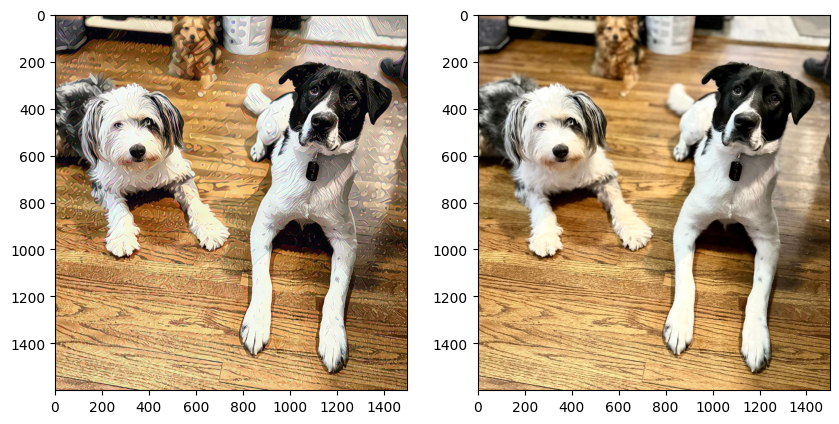

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))


axs[0].imshow(x)
axs[1].imshow(y)